# PIT Summary nonlinear

# Purpose
There has been a lot done in the parameter identification techniques (PIT) in this project, this notebook is a summary.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

#import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_martin_vmm as vmm
#import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as vmm
import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as model
from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
Math(vlatex(eq.X_eq))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

In [4]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [5]:
Math(vlatex(eq.X_eq.rhs-eq.X_eq.lhs))

<IPython.core.display.Math object>

In [6]:
Math(vlatex(eq.Y_eq.rhs-eq.Y_eq.lhs))

<IPython.core.display.Math object>

In [7]:
Math(vlatex(eq.N_eq.rhs-eq.N_eq.lhs))

<IPython.core.display.Math object>

## Load test

In [8]:
#id=22773
#id=22616
id=22774
#id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df['t'] = df.index
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

df['thrust'] = df['Prop/PS/Thrust'] + df['Prop/SB/Thrust']
df['U'] = df['V']
df['beta'] = -np.arctan2(df['v'],df['u'])

In [9]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']

<AxesSubplot:xlabel='time'>

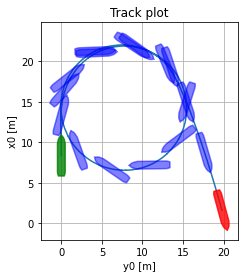

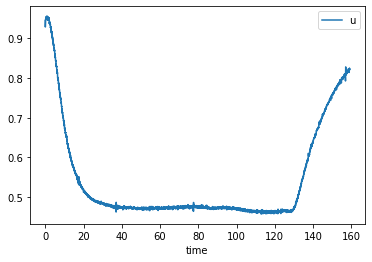

In [10]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
df.plot(y='u')

# Ship parameters

In [11]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2
#I_z_=839.725

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        #'x_G' : meta_data.lcg,  # motions are expressed at CG
        'x_G' : 0,  # motions are expressed at CG
        
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship
ship_parameters_prime = ps.prime(ship_parameters)

In [12]:
I_z_+m_*meta_data.lcg**2  # Steiner rule...

719.4503668233929

In [13]:
I_z_

693.124396594905

In [14]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

In [15]:
ship_parameters_prime

{'T': 0.04114230396902224,
 'L': 1.0,
 'CB': 0.45034232324249973,
 'B': 0.1887705711519845,
 'rho': 2.0,
 'x_G': 0.0,
 'm': 0.006995127873817863,
 'I_z': 0.00043719549211361644,
 'volume': 0.003497563936908932}

## Prime system

In [16]:
interesting = ['x0','y0','psi','u','v','r','u1d','v1d','r1d','U','t','delta','thrust','beta']
df_prime = ps.prime(df[interesting], U=df['U'])
df_prime.set_index('t', inplace=True)

<AxesSubplot:xlabel='t'>

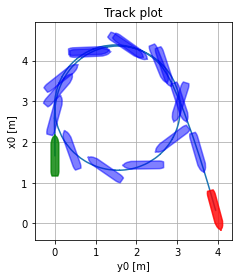

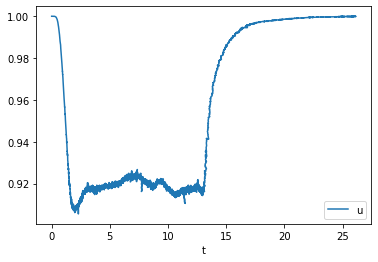

In [17]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],
           x_dataset='x0', y_dataset='y0',  psi_dataset='psi', ax=ax);

df_prime.plot(y='u')

In [18]:
df.index

Float64Index([                 0.0, 0.010002000000000066, 0.020001999999999853,
               0.03002200000000066,  0.04000199999999943,  0.05000099999999996,
               0.06000200000000078,   0.0700219999999998,  0.08000099999999932,
                0.0899990000000006,
              ...
                        159.050005,           159.060013,               159.07,
                        159.080005,           159.090005,           159.100006,
                        159.110017,           159.120001,           159.130005,
                        159.140008],
             dtype='float64', name='time', length=15915)

In [19]:
df_prime.index

Float64Index([                  0.0, 0.0018590505176670773,
               0.003703278795339165,  0.005567789136387368,
                0.00743809610775319,  0.009300584387083548,
                0.01116513279812117,   0.01306781836916762,
               0.014973821105671309,  0.016852159385169353,
              ...
                 26.016530241872566,     26.08549683298727,
                 26.155073443087844,     26.15859030345773,
                 26.144083237296872,     26.12877144218778,
                 26.116362811864647,    26.101964884226014,
                  26.08629050013182,    26.075838054271756],
             dtype='float64', name='t', length=15915)

In [20]:
t_ = np.array([0,1,2])
U_ = np.array([1,2,2])
t_prime = ps._prime(t_, unit='time', U=U_)
t_prime

array([0.        , 0.39883833, 0.79767667])

In [21]:
ps._unprime(t_prime, unit='time', U=U_)

array([0., 1., 2.])

# Brix parameters

In [22]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

df_parameters.loc['Ydelta','brix_prime'] = 0.0004  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/4  # Just guessing

df_parameters['brix_prime'].fillna(0, inplace=True)
#df_parameters['brix_SI'].fillna(0, inplace=True)



## Simulate with Brix

In [23]:
X_eq = eq.X_eq.copy()
Y_eq = eq.Y_eq.copy()
N_eq = eq.N_eq.copy()


#subs=[
#    #(x_G,0),
#    (eq.p.Xvdot,0),
#    (eq.p.Xrdot,0),
#    (eq.p.Yudot,0),
#    (eq.p.Yrdot,0),
#    (eq.p.Nudot,0),
#    (eq.p.Nvdot,0),   
#]
#
#X_eq = X_eq.subs(subs)
#Y_eq = Y_eq.subs(subs)
#N_eq = N_eq.subs(subs)


eqs = [X_eq, Y_eq, N_eq]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()])


## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)





In [24]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, ship_parameters, control):

    u,v,r,x0,y0,psi = states
    
    if u < 0:
        dstates = [
        0,
        0,
        0,
        0,
        0,
        0,
        ]    
        return dstates
    
    states_dict = {
        'u':u,
        'v':v,
        'r':r,
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
    
    inputs = dict(parameters)
    inputs.update(ship_parameters)
    inputs.update(states_dict)
    
    if isinstance(control, pd.DataFrame):
        index = np.argmin(np.array(np.abs(control.index - t)))
        control_ = dict(control.iloc[index])
    else:
        control_ = control
    inputs.update(control_)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    u1d = run(function=u1d_lambda, inputs=inputs)
    v1d = run(function=v1d_lambda, inputs=inputs)
    r1d = run(function=r1d_lambda, inputs=inputs)
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    
    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    return dstates

<AxesSubplot:xlabel='t'>

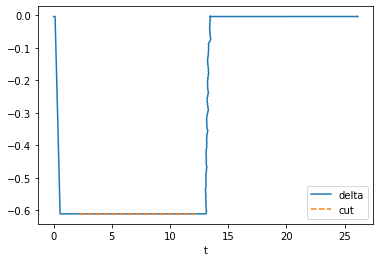

In [25]:
fig,ax=plt.subplots()
df_prime.plot(y='delta', ax=ax)
df_cut_prime = df_prime.iloc[2000:12000]
df_cut_prime.plot(y='delta', ax=ax, style='--', label='cut')

In [26]:
def simulate(df_, parameters, ship_parameters):
    
    t = df_.index
    t_span = [t.min(),t.max()]
    t_eval = np.linspace(t.min(),t.max(),len(t))
    
    #control = df_[['delta','thrust']]
    control = {
        'delta': float(df_['delta'].mean()),
        'thrust': float(df_['thrust'].mean()),
        
    }
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi']
        }
    
    solution = solve_ivp(fun=step, t_span=t_span, y0=list(y0.values()), t_eval=t_eval, 
                args=(parameters, ship_parameters, control))
    
    columns = list(y0.keys())
    df_result = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result.index=t[0:len(df_result)]
    
    df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
    
    return solution, df_result

In [27]:
df_parameters.loc['Xthrust','brix_prime']

0.0

In [28]:
solution, df_result_brix = simulate(df_cut_prime, parameters = df_parameters['brix_prime'], ship_parameters=ship_parameters_prime)

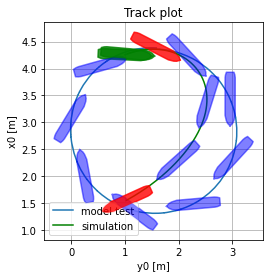

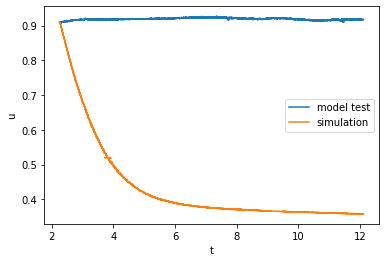

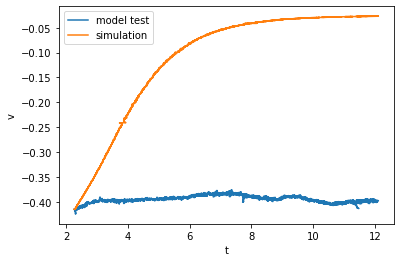

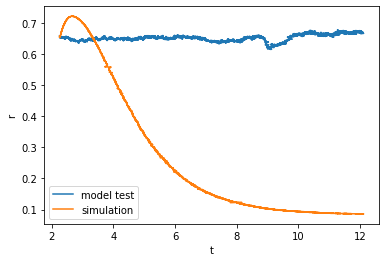

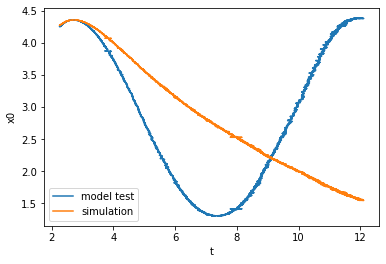

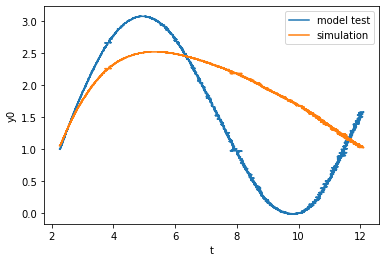

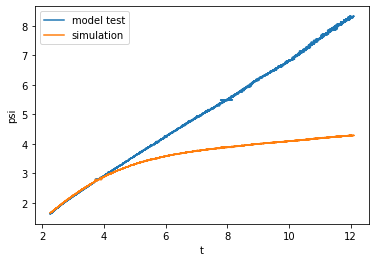

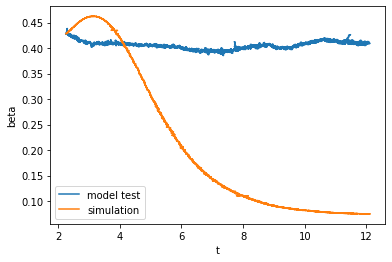

In [29]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_brix, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_brix:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_brix.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

## Back to SI

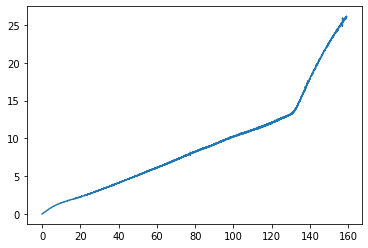

In [30]:
fig,ax=plt.subplots()
ax.plot(df.index,df_prime.index)

In [31]:
U_ = ship_parameters['L']*df_prime.index/df.index
df_unprime = ps.unprime(df_prime, U=U_)
df_unprime.index = ps._unprime(df_prime.index,unit='time',U=U_)

<AxesSubplot:xlabel='time'>

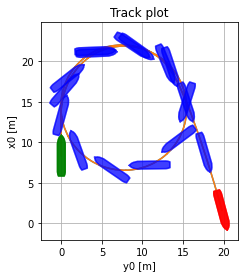

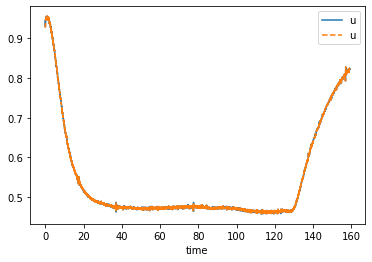

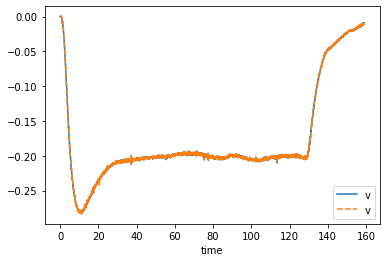

In [32]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
track_plot(df=df_unprime, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

fig,ax=plt.subplots()
df.plot(y='u',ax=ax)
df_unprime.plot(y='u', style='--', ax=ax)

fig,ax=plt.subplots()
df.plot(y='v',ax=ax)
df_unprime.plot(y='v', style='--', ax=ax)

# VCT regression

## Load VCT data

In [33]:
df_VCT_all = pd.read_csv('../data/external/vct.csv', index_col=0)
df_VCT_all.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
0,165,7.3,7375.872,7277.256591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173333,0.0,-0.000000,-261193.992917,-252076.078409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1308.975604,-295.088406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.879028e+06,-5.881622e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80665,196.0,5.778834e+02,-1085.233044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173220e+08,6.178902e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236840e+05,2.386122e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,1025.0,6.173333,-0.0,12knotsResistance,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,0.0,0.0,0,0,HERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.61946

In [34]:
df_VCT = df_VCT_all.groupby(by=['model_name']).get_group('V2_5_MDL_modelScale')

In [35]:
df_VCT['test type'].unique()

array(['resistance', 'Rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Circle', 'Circle + Drift'], dtype=object)

# Subtract the resistance

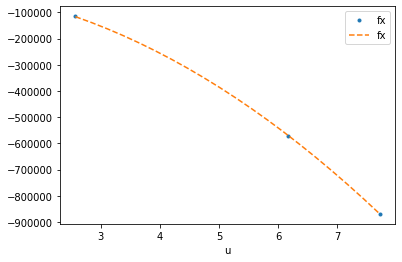

In [36]:
df_resistance = df_VCT.groupby(by='test type').get_group('resistance')

X = df_resistance[['u','fx']].copy()
X['u**2'] = X['u']**2
y = X.pop('fx')

model_resistance = sm.OLS(y,X)
results_resistance = model_resistance.fit()

X_pred = pd.DataFrame()
X_pred['u'] = np.linspace(X['u'].min(), X['u'].max(), 20)
X_pred['u**2'] = X_pred['u']**2
X_pred['fx'] = results_resistance.predict(X_pred)

fig,ax=plt.subplots()
df_resistance.plot(x='u', y='fx', style='.', ax=ax)
X_pred.plot(x='u', y='fx', style='--', ax=ax);


In [37]:
df_VCT_0_resistance = df_VCT.copy()
df_VCT_0_resistance['u**2'] = df_VCT_0_resistance['u']**2
#df_VCT_0_resistance['fx']-= results_resistance.predict(df_VCT_0_resistance[['u','u**2']])
df_VCT_0_resistance['thrust'] = results_resistance.predict(df_VCT_0_resistance[['u','u**2']])

## VCT to prime system

In [38]:
interesting = [
    'u',
    'v',
    'r',
    'delta',
    'fx',
    'fy',
    'mz',
    'thrust',
]
df_VCT_prime = ps_ship.prime(df_VCT_0_resistance[interesting], U=df_VCT_0_resistance['V'])

In [39]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred_vct(X,y,results, label):
    
    display(results.summary())
    
    X_ = X.copy()
    X_['y'] = y
    X_.sort_values(by='y', inplace=True)
        
    y_ = X_.pop('y')
    
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    #ax.plot(X_.index,y_, label='Numerical gradient from model test')
    #ax.plot(X_.index,y_pred, '--', label='OLS')
    
    ax.plot(y_,y_pred, '.')
    ax.plot([y_.min(),y_.max()], [y_.min(),y_.max()], 'r-')
    
    ax.set_ylabel(f'{label} (prediction)')    
    ax.set_xlabel(label)
    
    ax.fill_between(y_, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5% confidence')
    ax.legend();

## N

In [40]:
eq.N_qs_eq

Eq(N_qs(u(t), v(t), r(t), delta(t)), N_{delta}*delta(t) + N_{r}*r(t) + N_{u}*u(t) + N_{v}*v(t))

In [41]:
label = sp.symbols('N_qs')
N_eq_ = eq.N_qs_eq.subs(N_qs,label)
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq_, label=label, base_features=[delta,u,v,r])

In [42]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1051.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                    1.89e-33
Time:                        13:42:57   Log-Likelihood:                          310.40
No. Observations:                  36   AIC:                                     -612.8
Df Residuals:                      32   BIC:                                     -606.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0026      0.000    -26.455      0.000      -0.003      -0.002
Nr            -0.0026   5.86e-05    -45.023      0.000      -0.003      -0.003
Nu         -4.849e-05    1.4e-05     -3.460      0.002    -7.7e-05   -1.99e-05
Nv            -0.0020      0.000    -12.675      0.000      -0.002      -0.002
==============================================================================
Omnibus:                        4.736   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.474
Skew:                           0.499   Prob(JB):                        0.176
Kurtosis:                       4.149   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

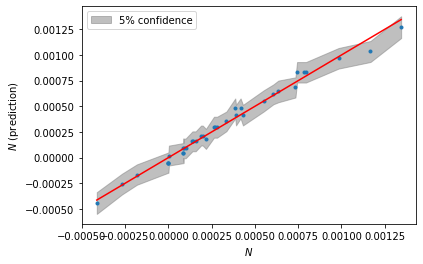

In [43]:
X = diff_eq_N.calculate_features(data=df_VCT_prime)
y = diff_eq_N.calculate_label(y=df_VCT_prime['mz'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred_vct(X=X,y=y,results=results_N, label=r'$N$')

## Y

In [44]:
eq.Y_qs_eq

Eq(Y_qs(u(t), v(t), r(t), delta(t)), Y_{delta}*delta(t) + Y_{r}*r(t) + Y_{u}*u(t) + Y_{v}*v(t))

In [45]:
label = sp.symbols('Y_qs')
Y_eq_ = eq.Y_qs_eq.subs(Y_qs,label)
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq_, label=label, base_features=[delta,u,v,r])

In [46]:
Math(vlatex(diff_eq_Y.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1185.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                    2.83e-34
Time:                        13:42:58   Log-Likelihood:                          282.55
No. Observations:                  36   AIC:                                     -557.1
Df Residuals:                      32   BIC:                                     -550.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0044      0.000     20.359      0.000       0.004       0.005
Yr             0.0024      0.000     18.545      0.000       0.002       0.003
Yu            -0.0001   3.04e-05     -3.563      0.001      -0.000   -4.64e-05
Yv            -0.0133      0.000    -39.314      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        4.535   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                1.772
Skew:                          -0.053   Prob(JB):                        0.412
Kurtosis:                       1.918   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

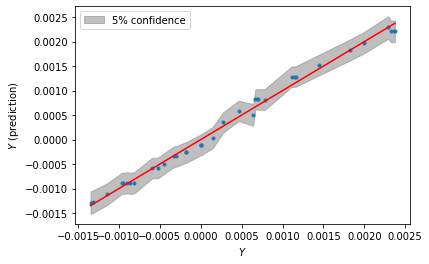

In [47]:
X = diff_eq_Y.calculate_features(data=df_VCT_prime)
y = diff_eq_Y.calculate_label(y=df_VCT_prime['fy'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred_vct(X=X,y=y,results=results_Y, label=r'$Y$')

## X

In [48]:
eq.X_qs_eq

Eq(X_qs(u(t), v(t), r(t), delta(t)), X_{deltadelta}*delta(t)**2 + X_{rr}*r(t)**2 + X_{thrust}*thrust(t) + X_{uu}*u(t)**2 + X_{vr}*r(t)*v(t))

In [49]:
label = sp.symbols('X_qs')
X_eq_ = eq.X_qs_eq.subs(X_qs,label)
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq_, label=label, base_features=[delta,u,v,r,thrust])

In [50]:
Math(vlatex(diff_eq_X.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              9054.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                    4.55e-48
Time:                        13:42:59   Log-Likelihood:                          338.53
No. Observations:                  36   AIC:                                     -667.1
Df Residuals:                      31   BIC:                                     -659.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta    -0.0028      0.000    -12.547      0.000      -0.003      -0.002
Xrr             0.0002   7.29e-05      2.116      0.042    5.59e-06       0.000
Xuu         -3.567e-05   5.05e-05     -0.707      0.485      -0.000    6.72e-05
Xvr            -0.0039      0.001     -7.635      0.000      -0.005      -0.003
Xthrust         0.9581      0.068     14.126      0.000       0.820       1.096
==============================================================================
Omnibus:                       25.014   Durbin-Watson:                   1.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.180
Skew:                          -1.629   Prob(JB):                     2.83e-12
Kurtosis:                       7.984   Cond. No.                     1.88e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

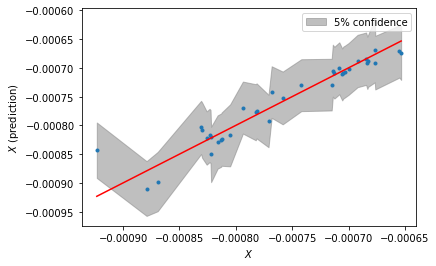

In [51]:
X = diff_eq_X.calculate_features(data=df_VCT_prime)
y = diff_eq_X.calculate_label(y=df_VCT_prime['fx'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred_vct(X=X,y=y,results=results_X, label=r'$X$')

In [52]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [53]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

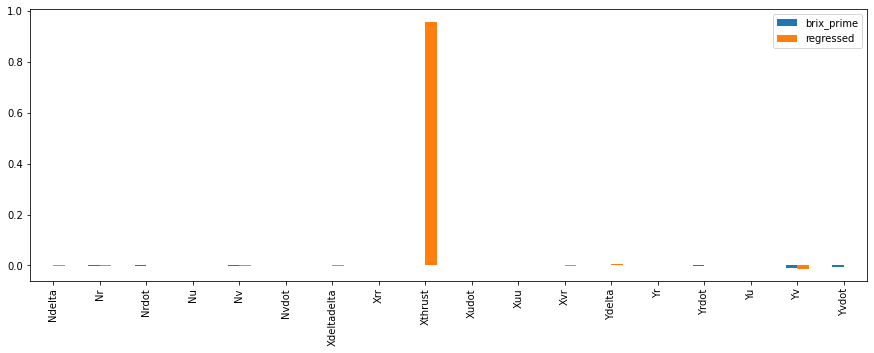

In [54]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])))
                
df_parameters_all_plot = df_parameters_all.loc[mask]
df_parameters_all_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

## Simulate

In [88]:
parameters = df_parameters_all['prime'].copy()
parameters['Xthrust']*=0.7
solution, df_result_VCT = simulate(df_cut_prime, parameters = parameters, ship_parameters=ship_parameters_prime)

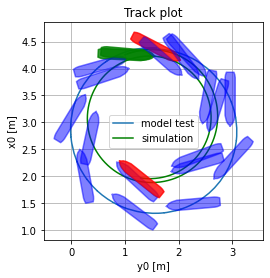

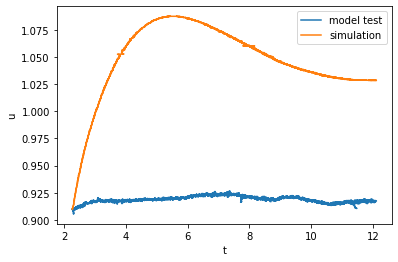

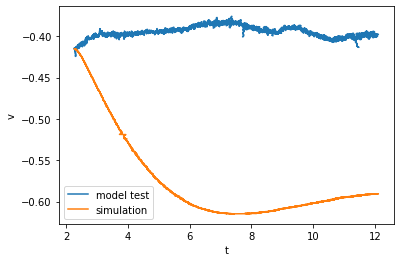

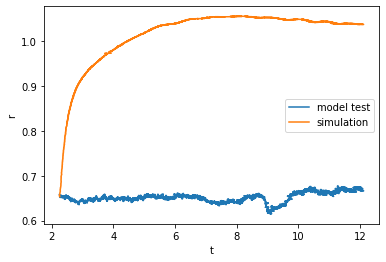

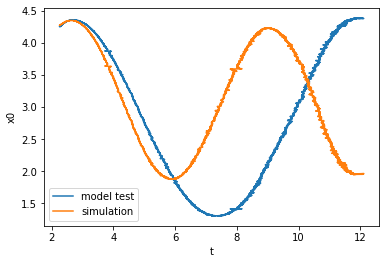

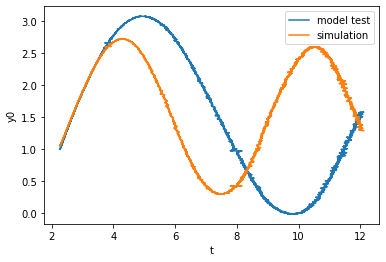

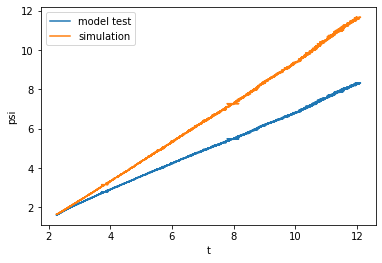

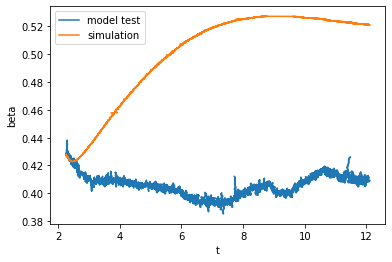

In [89]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_VCT, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_VCT:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_VCT.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

# Time series PIT

In [57]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

## N

In [58]:
N_eq_ = N_eq.copy()
N_eq_ = N_eq_.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(N_eq_,r.diff())[0]
inertia_ = (I_z-eq.p.Nrdot)
N_eq_ = sp.Eq(r.diff()*inertia_, solution*inertia_)


In [59]:
Math(vlatex(N_eq_))

<IPython.core.display.Math object>

In [60]:
label_N = N_eq_.lhs
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq_, label=label_N, base_features=[delta,u,v,r])

In [61]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

In [62]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [63]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [64]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\dot{v}}],
[  N_{delta}],
[      N_{r}],
[      N_{u}],
[      N_{v}]]))

In [65]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [66]:
diff_eq_N.y_lambda

<function _lambdifygenerated(I_z, Nrdot, r1d)>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          4.195e+04
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        13:43:03   Log-Likelihood:                      1.3743e+05
No. Observations:               15915   AIC:                                 -2.749e+05
Df Residuals:                   15910   BIC:                                 -2.748e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nvdot         -0.0026   1.68e-05   -158.063      0.000      -0.003      -0.003
Ndelta        -0.0012   1.22e-05   -101.434      0.000      -0.001      -0.001
Nr            -0.0009   1.44e-05    -58.946      0.000      -0.001      -0.001
Nu         -6.461e-06   9.89e-07     -6.532      0.000    -8.4e-06   -4.52e-06
Nv            -0.0035   3.08e-05   -114.314      0.000      -0.004      -0.003
==============================================================================
Omnibus:                     5173.450   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28039.026
Skew:                          -1.465   Prob(JB):                         0.00
Kurtosis:                       8.805   Cond. No.                         141.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

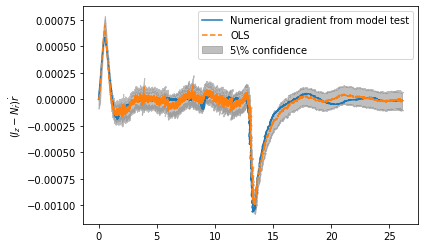

In [67]:
X = diff_eq_N.calculate_features(data=df_prime)
y = run(function=diff_eq_N.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$%s$' % vlatex(label_N))

## Y

In [68]:
Y_eq_ = Y_eq.copy()
Y_eq_ = Y_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(Y_eq_,v.diff())[0]
inertia_ = (eq.p.Yvdot-m)
Y_eq_ = sp.Eq(-(v.diff()*inertia_-u*m*r), -(solution*inertia_-u*m*r))

Math(vlatex(Y_eq_))

<IPython.core.display.Math object>

In [69]:
label_Y = Y_eq_.lhs
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq_, label=label_Y, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.208e+07
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        13:43:03   Log-Likelihood:                      1.1494e+05
No. Observations:               15915   AIC:                                 -2.299e+05
Df Residuals:                   15910   BIC:                                 -2.298e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yrdot         -0.0023    1.5e-05   -153.440      0.000      -0.002      -0.002
Ydelta        -0.0013   6.37e-05    -20.245      0.000      -0.001      -0.001
Yr             0.0062   6.53e-05     95.531      0.000       0.006       0.006
Yu          -5.31e-05   3.95e-06    -13.452      0.000   -6.08e-05   -4.54e-05
Yv            -0.0184   4.99e-05   -368.998      0.000      -0.019      -0.018
==============================================================================
Omnibus:                      401.333   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.649
Skew:                           0.368   Prob(JB):                     1.03e-97
Kurtosis:                       3.363   Cond. No.                         80.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

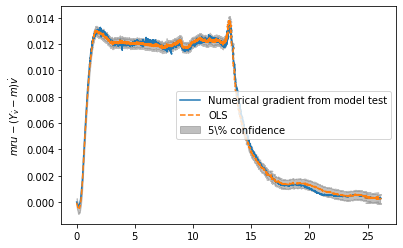

In [70]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = run(function=diff_eq_Y.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$%s$' % vlatex(label_Y))

## X

In [71]:
X_eq_ = X_eq.copy()
X_eq_ = X_eq_.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(X_eq_,u.diff())[0]
inertia_ = m-eq.p.Xudot
X_eq_ = sp.Eq((u.diff()*inertia_-m*r*v), (solution*inertia_-m*r*v))

Math(vlatex(X_eq_))

<IPython.core.display.Math object>

In [72]:
label_X = X_eq_.lhs
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq_, label=label_X, base_features=[delta,u,v,r,thrust])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.262e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        13:43:04   Log-Likelihood:                      1.2854e+05
No. Observations:               15915   AIC:                                 -2.571e+05
Df Residuals:                   15910   BIC:                                 -2.570e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta    -0.0025   1.89e-05   -130.512      0.000      -0.002      -0.002
Xrr            -0.0008   3.41e-05    -22.517      0.000      -0.001      -0.001
Xuu            -0.0006   2.37e-06   -257.481      0.000      -0.001      -0.001
Xvr            -0.0084   4.97e-05   -168.354      0.000      -0.008      -0.008
Xthrust         0.7342      0.001    770.295      0.000       0.732       0.736
==============================================================================
Omnibus:                      211.398   Durbin-Watson:                   0.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.289
Skew:                           0.220   Prob(JB):                     9.98e-56
Kurtosis:                       3.434   Cond. No.                     1.62e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

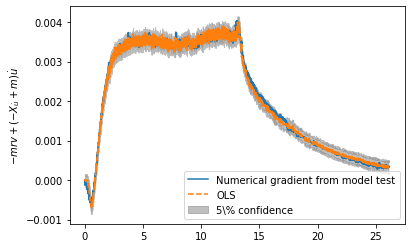

In [73]:
X = diff_eq_X.calculate_features(data=df_prime)
y = run(function=diff_eq_X.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$%s$' % vlatex(label_X))

In [74]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add regressed parameters

In [75]:
results = pd.concat([results_summary_X, results_summary_Y, results_summary_N],axis=0)
df_parameters_all['PIT'] = results['coeff']
df_parameters_all['PIT'] = df_parameters_all['PIT'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

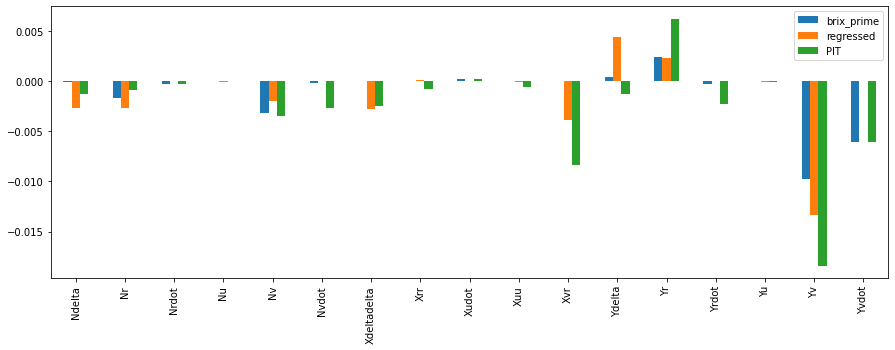

In [76]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])) | 
        (df_parameters_all['PIT']!=0)
        
       )
                
df_parameters_all_plot = df_parameters_all.loc[mask]

df_parameters_all_plot.drop(index=['Xthrust']).plot.bar(y=['brix_prime','regressed','PIT'], ax=ax);

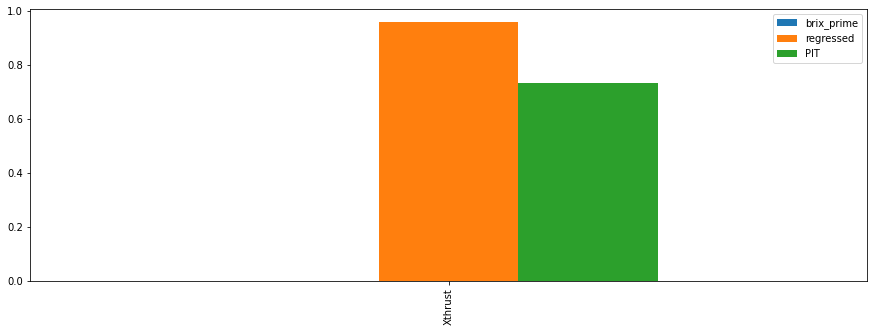

In [77]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
df_parameters_all_plot.loc[['Xthrust']].plot.bar(y=['brix_prime','regressed','PIT'], ax=ax);

## Simulate

In [78]:
parameters = df_parameters_all['PIT'].copy()
#parameters['Xv']=0
#parameters['Xr']=0
#parameters['Xu']=0
#parameters['Xdelta']=0
#parameters['Nv']*=-1



solution, df_result_PIT = simulate(df_cut_prime, parameters = parameters, ship_parameters=ship_parameters_prime)

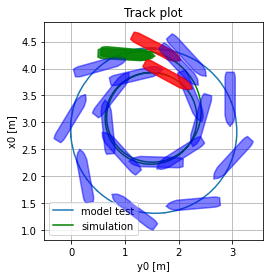

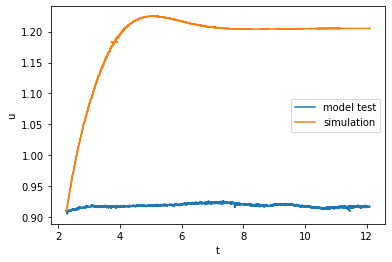

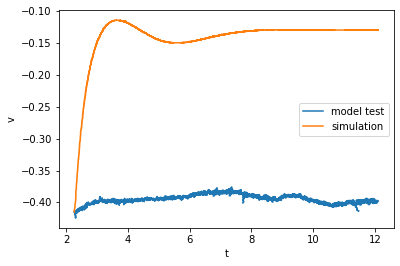

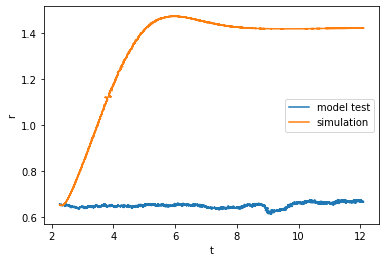

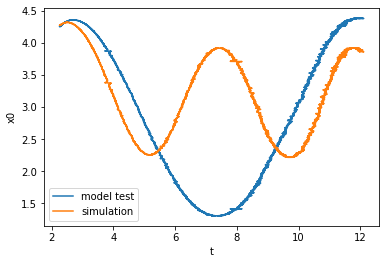

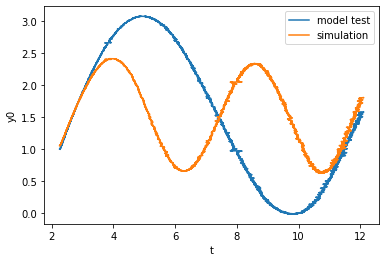

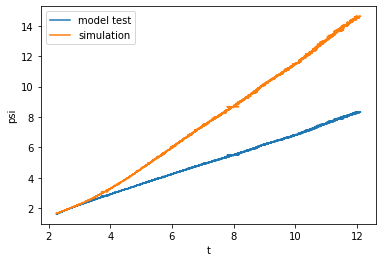

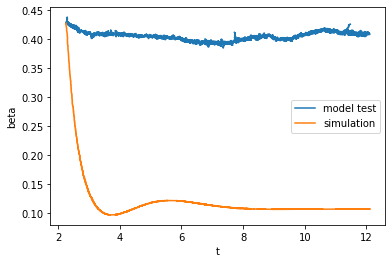

In [79]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_PIT, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_PIT:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_PIT.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

In [90]:
X_eq

Eq(m*(-x_G*r(t)**2 - r(t)*v(t) + Derivative(u(t), t)), X_{\dot{u}}*Derivative(u(t), t) + X_{deltadelta}*delta(t)**2 + X_{rr}*r(t)**2 + X_{thrust}*thrust(t) + X_{uu}*u(t)**2 + X_{vr}*r(t)*v(t))

In [104]:
u1d,v1d,r1d = sp.symbols('u1d, v1d, r1d')
subs = [
    (u.diff(),u1d),
    (v.diff(),v1d),
    (r.diff(),r1d),

]
eq_X_ = X_eq.subs(subs)
eq_Y_ = Y_eq.subs(subs)
eq_N_ = N_eq.subs(subs)


A,b = sp.linear_eq_to_matrix([eq_X_,eq_Y_,eq_N_],[u1d,v1d,r1d])

In [105]:
A

Matrix([
[-X_{\dot{u}} + m,                    0,                    0],
[               0,     -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])

In [108]:
Math(vlatex(b))

<IPython.core.display.Math object>

In [107]:
A.inv()

Matrix([
[1/(-X_{\dot{u}} + m),                                                                                                                                                                          0,                                                                                                                                                                          0],
[                   0,   (-I_z + N_{\dot{r}})/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}}*Y_{\dot{v}} + N_{\dot{r}}*m + N_{\dot{v}}*Y_{\dot{r}} - N_{\dot{v}}*m*x_G - Y_{\dot{r}}*m*x_G + m**2*x_G**2), (-Y_{\dot{r}} + m*x_G)/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}}*Y_{\dot{v}} + N_{\dot{r}}*m + N_{\dot{v}}*Y_{\dot{r}} - N_{\dot{v}}*m*x_G - Y_{\dot{r}}*m*x_G + m**2*x_G**2)],
[                   0, (-N_{\dot{v}} + m*x_G)/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}}*Y_{\dot{v}} + N_{\dot{r}}*m + N_{\dot{v}}*Y_{\dot{r}} - N_{\dot{v}}*m*x_G - Y_{\dot{r}}*m*x_G + m**2*x_G**2),      (Y_{\dot{v}} - m)/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}